In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [ ]:
# --- Load demand_core from CSV (weather_core folder) ---
core_path = "../../data/Weather_Data/weather_core/demand_core.csv"

df = pd.read_csv(core_path, parse_dates=["datetime_hour"])
print("Columns in demand_core:", df.columns.tolist())
print("Shape:", df.shape)

# Keep only rows with positive demand
df = df[df["pickups"] > 0].copy()

# Log-transform target
df["log_pickups"] = np.log1p(df["pickups"])

# Boolean → numeric for regression
df["is_rain_int"] = df["is_rain"].astype(int)

# Categorical time features
cat_cols = ["hour", "dow"]
X_cat = pd.get_dummies(
    df[cat_cols].astype("category"),
    drop_first=True  # avoid full multicollinearity
)

# Base features: only time
X_base = X_cat.copy()

# Extended features: time + weather
X_weather = pd.concat(
    [X_cat, df[["temp_C", "is_rain_int"]]],
    axis=1
)
# Interaction temperature × rain
X_weather["tempC_x_rain"] = X_weather["temp_C"] * X_weather["is_rain_int"]

y = df["log_pickups"]

# Time-based train–test split: train = Jan–Oct, test = Nov–Dec
train_mask = df["datetime_hour"] < pd.Timestamp("2018-11-01")

X_base_train = X_base[train_mask]
X_base_test  = X_base[~train_mask]

X_weather_train = X_weather[train_mask]
X_weather_test  = X_weather[~train_mask]

y_train = y[train_mask]
y_test  = y[~train_mask]

print("Train rows:", len(y_train))
print("Test rows :", len(y_test))


Columns in demand_core: ['datetime_hour', 'pickups', 'temp_C', 'precip_in', 'wind_speed_kn', 'rhum', 'is_rain', 'is_snow_like', 'is_dry', 'hour', 'dow', 'is_weekend', 'month', 'temp_bin']
Shape: (8393, 14)
Train rows: 6994
Test rows : 1399


In [6]:
# Fit base model (time only)
model_base = LinearRegression()
model_base.fit(X_base_train, y_train)

# Fit extended model (time + weather)
model_weather = LinearRegression()
model_weather.fit(X_weather_train, y_train)

def evaluate(model, Xtr, Xte, ytr, yte, label):
    ytr_pred = model.predict(Xtr)
    yte_pred = model.predict(Xte)
    print(f"\n=== {label} ===")
    print("Train R^2:", round(r2_score(ytr, ytr_pred), 3))
    print("Test  R^2:", round(r2_score(yte, yte_pred), 3))

evaluate(model_base, X_base_train, X_base_test, y_train, y_test, "Base (time only)")
evaluate(model_weather, X_weather_train, X_weather_test, y_train, y_test, "Time + weather")

# Inspect weather-related coefficients (on log scale)
coef_weather = pd.Series(model_weather.coef_, index=X_weather.columns)
print("\nWeather-related coefficients:")
print(coef_weather[["temp_C", "is_rain_int", "tempC_x_rain"]])



=== Base (time only) ===
Train R^2: 0.753
Test  R^2: 0.735

=== Time + weather ===
Train R^2: 0.851
Test  R^2: 0.805

Weather-related coefficients:
temp_C          0.041796
is_rain_int    -0.460730
tempC_x_rain    0.011003
dtype: float64


In [7]:
# Align test indices
test_idx = X_base_test.index

reg_test = df.loc[test_idx, ["datetime_hour", "pickups"]].copy()
reg_test = reg_test.sort_values("datetime_hour")

# True log target
reg_test["y_true_log"] = y.loc[test_idx]

# Log predictions
reg_test["y_pred_base_log"] = model_base.predict(X_base_test)
reg_test["y_pred_weather_log"] = model_weather.predict(X_weather_test)

# Back-transform to level (pickups)
reg_test["pickups_true"] = np.expm1(reg_test["y_true_log"])
reg_test["pickups_pred_base"] = np.expm1(reg_test["y_pred_base_log"])
reg_test["pickups_pred_weather"] = np.expm1(reg_test["y_pred_weather_log"])

reg_test.head()


,datetime_hour,pickups,y_true_log,y_pred_base_log,y_pred_weather_log,pickups_true,pickups_pred_base,pickups_pred_weather
6994,2018-11-01 00:00:00,533,6.280396,5.986897,6.025275,533.0,397.177259,412.755207
6995,2018-11-01 01:00:00,295,5.690359,5.375998,5.434885,295.0,215.155534,228.266566
6996,2018-11-01 02:00:00,163,5.099866,4.777278,4.828401,163.0,117.780534,124.010966
6997,2018-11-01 03:00:00,125,4.836282,4.328270,4.339737,125.0,74.813042,75.687357
6998,2018-11-01 04:00:00,129,4.867534,4.498198,4.549273,129.0,88.855027,93.563601


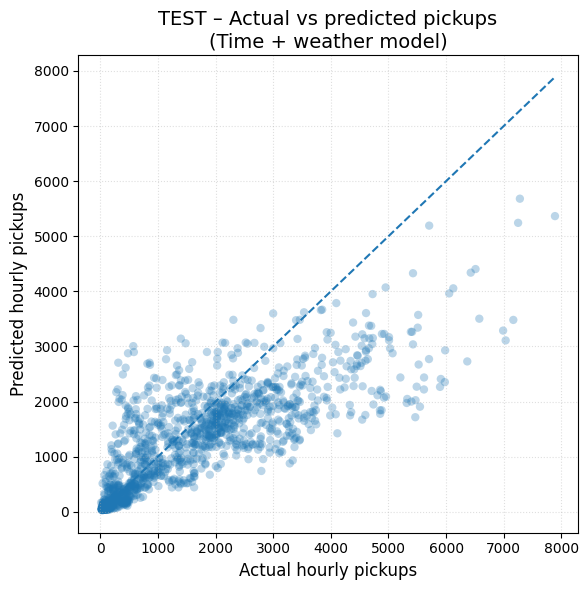

In [8]:
plt.figure(figsize=(6, 6))

plt.scatter(
    reg_test["pickups_true"],
    reg_test["pickups_pred_weather"],
    alpha=0.3,
    edgecolors="none"
)

# 45-degree reference line
min_val = min(reg_test["pickups_true"].min(), reg_test["pickups_pred_weather"].min())
max_val = max(reg_test["pickups_true"].max(), reg_test["pickups_pred_weather"].max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")

plt.title("TEST – Actual vs predicted pickups\n(Time + weather model)", fontsize=14)
plt.xlabel("Actual hourly pickups", fontsize=12)
plt.ylabel("Predicted hourly pickups", fontsize=12)
plt.grid(True, linestyle=":", alpha=0.4)

plt.tight_layout()
plt.show()


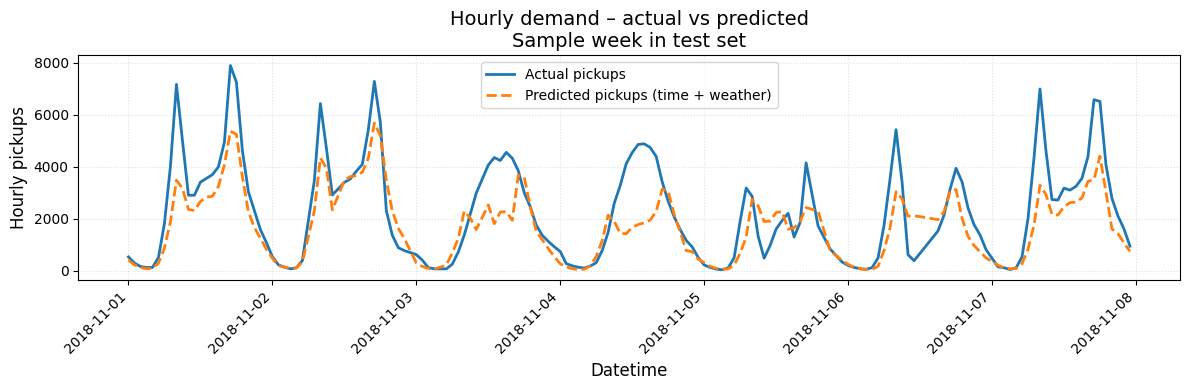

In [9]:
# Choose a sample week in the test period
start_date = "2018-11-01"
end_date = "2018-11-08"

week_mask = (
    (reg_test["datetime_hour"] >= start_date) &
    (reg_test["datetime_hour"] < end_date)
)
week_df = reg_test[week_mask].copy()

plt.figure(figsize=(12, 4))

plt.plot(
    week_df["datetime_hour"],
    week_df["pickups_true"],
    label="Actual pickups",
    linewidth=2,
)

plt.plot(
    week_df["datetime_hour"],
    week_df["pickups_pred_weather"],
    label="Predicted pickups (time + weather)",
    linewidth=2,
    linestyle="--",
)

plt.title("Hourly demand – actual vs predicted\nSample week in test set", fontsize=14)
plt.xlabel("Datetime", fontsize=12)
plt.ylabel("Hourly pickups", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(True, linestyle=":", alpha=0.4)
plt.legend()

plt.tight_layout()
plt.show()
